In [78]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [79]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pyTVDN.tmpUtils import *
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict as ddict
from tqdm import tqdm_notebook as tqdm
import pickle
from scipy.signal import lfilter, firls, decimate
from numpy.linalg import inv, svd
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.edgecolor"] = "0.3"
#plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams['axes.labelcolor']='black'

In [80]:
saveDir = Path("../results/fMRIHPFs_sep")
fil = list(saveDir.glob("*healthy.pkl"))[0]
print(fil)

with open(fil, "rb") as f:
    TVDNres = pickle.load(f)

../results/fMRIHPFs_sep/fMRIResultAdap_healthy.pkl


In [81]:
# Load results for difference fcts before the h
fils = list(saveDir.glob("*Adap_healthy_*.pkl"))
fils = sorted(fils, key=lambda x: int(x.stem.split("fct")[-1]))
print(fils)

[PosixPath('../results/fMRIHPFs_sep/fMRIResultAdap_healthy_fct8.pkl'), PosixPath('../results/fMRIHPFs_sep/fMRIResultAdap_healthy_fct18.pkl'), PosixPath('../results/fMRIHPFs_sep/fMRIResultAdap_healthy_fct34.pkl'), PosixPath('../results/fMRIHPFs_sep/fMRIResultAdap_healthy_fct60.pkl'), PosixPath('../results/fMRIHPFs_sep/fMRIResultAdap_healthy_fct86.pkl'), PosixPath('../results/fMRIHPFs_sep/fMRIResultAdap_healthy_fct174.pkl')]


In [82]:
import rpy2.robjects as robj
robj.r.source("../Rcode/utils.R")

RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]

# Distribution of num of changes and ranks

In [83]:
wsizes = [5, 10, 20, 35, 50, 100]
rank = 0
numChgswAll = {}

for wsize in wsizes:
    numChgsw = ddict(list)
    for DetObj in tqdm(TVDNres.DetObjs):
        Ymat = DetObj.Ymat
        d, n = Ymat.shape
        seqw = np.arange(1, n-wsize, 4)
        rSeqw = py2Rvec(seqw)
        rYmat = py2Rmat(Ymat)
        
        
        rDCORres = RsegCorr(rYmat, wsize, rSeqw)
        rDCORecpts = RchgF(rDCORres, rSeqw)
        numChgsw["DCOR"].append(np.array(rDCORecpts))
        
        # Detection results for PCA
        rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=rank)
        rPCAecpts = RchgF(rPCAres, rSeqw)
        numChgsw["PCA"].append(np.array(rPCAecpts))
        
        # Detection results for DMD
        rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
        rDMDecpts = RchgF(rDMDres, rSeqw)
        numChgsw["DMD"].append(np.array(rDMDecpts))
        
    numChgswAll[wsize] = numChgsw

In [96]:
numChgsCTAll = {}

for wsize in wsizes:
    numChgsCT = {}
    for key, v in numChgswAll[wsize].items():
        CT = Counter([len(ecpt) for ecpt in v])
        chgs = list(CT.keys())
        chgCts = [CT[chg] for chg in chgs]
        numChgsCT[key] = [chgs, chgCts]
        
    numChgsCTAll[wsize] = numChgsCT

### Ranks and num of changes for TVDN

In [97]:
numChgs = []
numRanks = []
for DetObj in TVDNres.DetObjs:
    numChgs.append(len(DetObj.ecpts))
    numRanks.append(DetObj.paras.r)
    
numChgsCt = Counter(numChgs)
numRanksCt = Counter(numRanks)

ranks = list(numRanksCt.keys())
ranks = sorted(ranks)
rCts = [numRanksCt[r] for r in ranks]

chgs = list(numChgsCt.keys())
chgCts = [numChgsCt[chg] for chg in chgs]

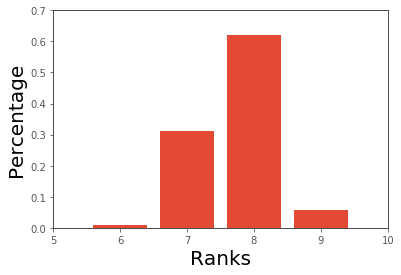

In [98]:
plt.figure(figsize=(6, 4))
plt.bar(ranks, np.array(rCts)/np.sum(rCts))
plt.xlabel("Ranks", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.xlim([5, 10])
plt.ylim([0, 0.7])
#plt.xlim([0, 35])
#plt.ylim([0, 1])
plt.savefig(f"../plots/fMRI_ranks_fct_half_healthy.jpg", bbox_inches='tight')

In [87]:
plt.figure(figsize=(6, 4))
plt.bar(chgs, np.array(chgCts)/np.sum(chgCts))
plt.xlabel("Num of switchings", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.xlim([4, 12])
plt.ylim([0, 0.6])
#plt.xlim([0, 35])
#plt.ylim([0, 1])
# half is because fct=0.5
plt.savefig(f"../plots/fMRI_cpts_fct_half_healthy.jpg", bbox_inches='tight')

In [88]:
fcts = np.array([0.04, 0.09, 0.17, 0.30, 0.43, 0.87]) * 100 * 2
numChgsCTTVDNAll = {}
numRanksCTTVDNAll = {}
for f, fct in zip(fils, fcts):
    with open(f, "rb") as f:
        tmpRes = pickle.load(f)
    tmpNumChgs = []
    tmpNumRanks = []
    for DetObj in tmpRes.DetObjs:
        tmpNumChgs.append(len(DetObj.ecpts))
        tmpNumRanks.append(DetObj.paras.r)
        
    tmpNumChgsCt = Counter(tmpNumChgs)
    tmpNumRanksCt = Counter(tmpNumRanks)
    
    ranks = list(tmpNumRanksCt.keys())
    ranks = sorted(ranks)
    rCts = [tmpNumRanksCt[r] for r in ranks]

    chgs = list(tmpNumChgsCt.keys())
    chgCts = [tmpNumChgsCt[chg] for chg in chgs]
    
    numChgsCTTVDNAll[fct] = [chgs, chgCts]
    numRanksCTTVDNAll[fct] = [ranks, rCts]

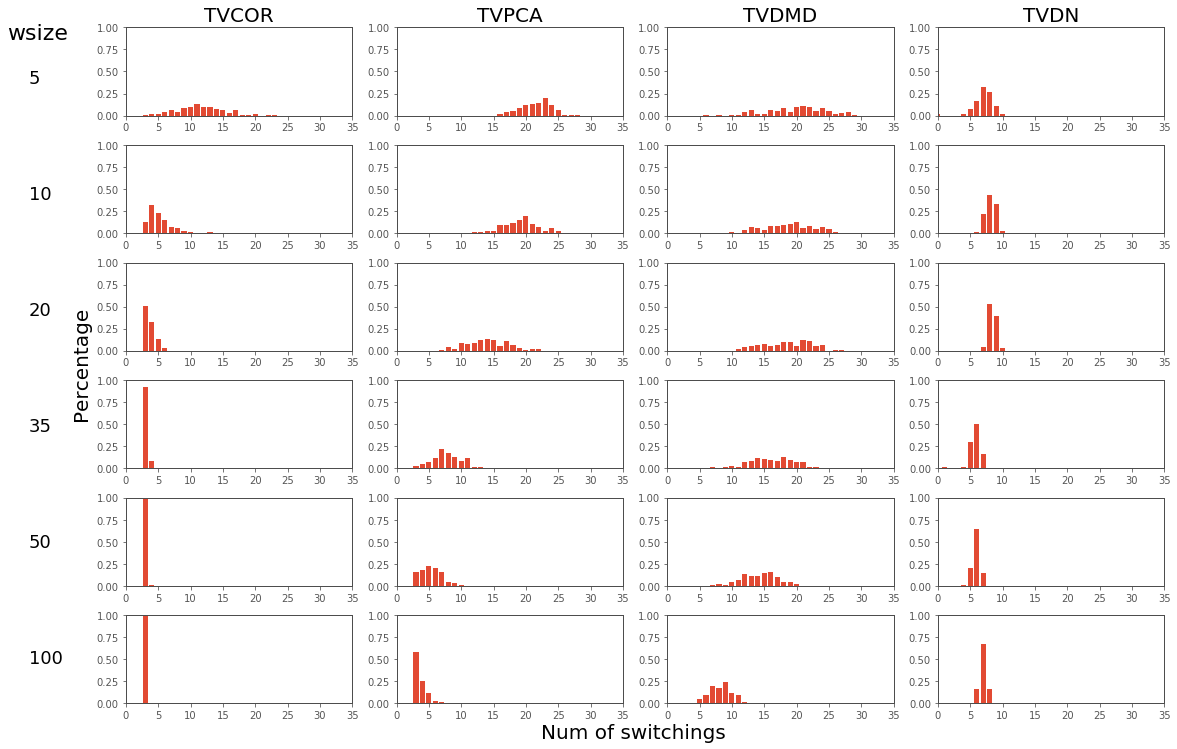

In [89]:
from matplotlib import gridspec
numData = len(TVDNres.DetObjs)

wsizesplot = wsizes#[:-1]

fig = plt.figure(figsize=(15, 10), constrained_layout=True)

gs = gridspec.GridSpec(len(wsizesplot), 8, figure=fig)

#ax0 = plt.subplot(gs[0,:4])
#ax1 = plt.subplot(gs[0,4:])
#axErr = plt.subplot(gs[0,4:])
#
#axErr.plot(numPts, mDMDErr, "--o", label="DMD")
#axErr.plot(numPts, mTVDNErr, "-h", label="TVDN")
#axErr.set_xticks(numPts[::5])
#axErr.legend()

ax2 = plt.subplot(gs[0,0:2])
ax3 = plt.subplot(gs[0,2:4], sharex=ax2, sharey=ax2)
ax4 = plt.subplot(gs[0,4:6], sharex=ax2, sharey=ax2)
ax1s = [ax2]
ax2s = [ax3]
ax3s = [ax4]
for ii in range(len(wsizesplot)-1):
    ax1s.append(plt.subplot(gs[ii+1,0:2], sharex=ax2, sharey=ax2))
    ax2s.append(plt.subplot(gs[ii+1,2:4], sharex=ax2, sharey=ax2))
    ax3s.append(plt.subplot(gs[ii+1,4:6], sharex=ax2, sharey=ax2))
    
# ax0.bar(chgs, np.array(chgCts)/numData)
# ax0.set_xlabel("Num of change points")
# ax0.set_ylabel("Percentage", color="black")
# ax0.set_ylim([0, 1])
# ax0.set_xlim([0, 35])
# 
# ax1.bar(ranks, np.array(rCts)/numData)
# ax1.set_xlabel("Ranks", fontsize=15)
# ax1.set_ylabel("Percentage", fontsize=15)

axTVDNs = []
for ii in range(len(fcts)):
    axTVDNs.append(plt.subplot(gs[ii+0,6:8], sharex=ax2, sharey=ax2))
    
for iidx, wsize in enumerate(wsizesplot):
    ax1s[iidx].bar(numChgsCTAll[wsize]["DCOR"][0], np.array(numChgsCTAll[wsize]["DCOR"][1])/numData)
    ax2s[iidx].bar(numChgsCTAll[wsize]["PCA"][0], np.array(numChgsCTAll[wsize]["PCA"][1])/numData)
    ax3s[iidx].bar(numChgsCTAll[wsize]["DMD"][0], np.array(numChgsCTAll[wsize]["DMD"][1])/numData)
    if iidx == 0:
        ax1s[iidx].set_ylim([0, 1])
        ax1s[iidx].set_xlim([0, 35])
        ax1s[iidx].set_title("TVCOR", fontsize=20)
        ax2s[iidx].set_title("TVPCA", fontsize=20)
        ax3s[iidx].set_title("TVDMD", fontsize=20)
        #ax1s[iidx].tick_params(labelbottom=False) # remove the axis labels

for jjdx, fct in enumerate(fcts):
    axTVDNs[jjdx].bar(numChgsCTTVDNAll[fct][0], np.array(numChgsCTTVDNAll[fct][1])/numData)
    if jjdx == 0:
        axTVDNs[jjdx].set_title("TVDN", fontsize=20)

#fig.text(-0.08, 1, "a", fontsize=25)
#fig.text(-0.08, 5/6, "b", fontsize=25)

fig.text(0.5, -0.02, 'Num of switchings', ha='center', fontsize=20, color="black")
fig.text(-0.02, 6/12, 'Percentage', va='center', rotation="vertical", fontsize=20, color="black")

fig.text(-0.08, 0.95, "wsize", rotation="horizontal", fontsize=22)
#fig.text(1.02, 0.95, "fct", rotation="horizontal", fontsize=22)
for ii, wsize in enumerate(wsizesplot[::-1]):
    fig.text(-0.06, 1/12+ii*1/(len(wsizesplot)+0.2), wsize, rotation="horizontal", fontsize=18)
    #fig.text(1.02, 1/12+ii*1/(len(wsizesplot)+0.2), fcts[::-1][ii]/10, rotation="horizontal", fontsize=18)
    #fig.text(-0.05, 1/60+ii*1/(len(wsizesplot)+1), f"wsize={wsize}", rotation="vertical", fontsize=20)
    
plt.savefig("../plots/fMRI_ncpt_healthy.jpg", bbox_inches='tight')

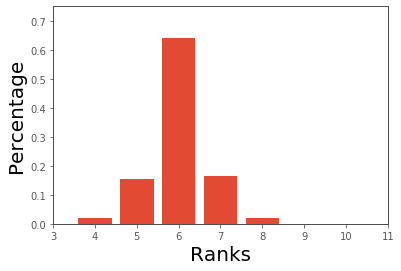

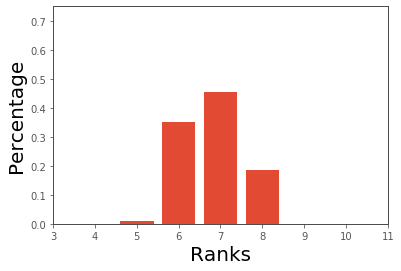

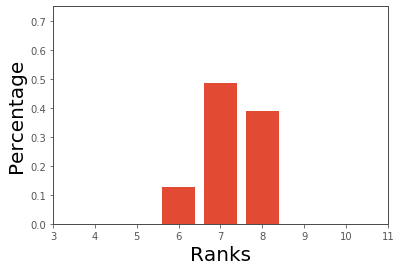

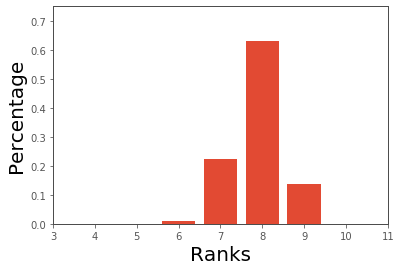

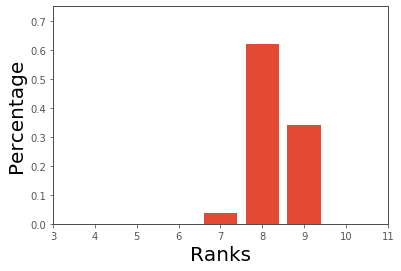

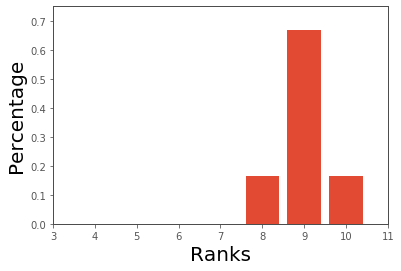

In [90]:
for fct in fcts:
    numRanksCTTVDN = numRanksCTTVDNAll[fct]
    ranks = numRanksCTTVDN[0]
    rCts = numRanksCTTVDN[1]
    plt.figure(figsize=(6, 4))
    plt.bar(ranks, np.array(rCts)/numData)
    plt.xlabel("Ranks", fontsize=20)
    plt.ylabel("Percentage", fontsize=20)
    plt.xlim([3, 11])
    plt.ylim([0, 0.75])
    plt.savefig(f"../plots/fMRI_rank_fct{fct}_healthy.jpg", bbox_inches='tight')

# Reconstructed Error vs num of change (DMD and TVDN)

In [91]:
tmpwsizes = [130, 140, 150]
ncens = [3, 2, 1]
for ncen, wsize in zip(ncens, tmpwsizes):
    restmp = ddict(list)
    for DetObj in tqdm(TVDNres.DetObjs):
        Ymat = DetObj.Ymat
        d, n = Ymat.shape
        seqw = np.arange(1, n-wsize, 4)
        rSeqw = py2Rvec(seqw)
        rYmat = py2Rmat(Ymat)
        rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
        rDMDecpts = RchgF(rDMDres, rSeqw, ncen)
        restmp["DMD"].append(np.array(rDMDecpts))
    numChgswAll[wsize] = restmp
    

In [92]:
# Obtain the Rec Error for DMD
DMDRecErrs = ddict(list)
wsizesF = np.concatenate([wsizes, tmpwsizes])
for wsize in tqdm(wsizesF):
    ii = 0
    for DetObj in TVDNres.DetObjs:
        Ymat = DetObj.nYmat
        ecpts = numChgswAll[wsize]["DMD"][ii]
        ecpts = ecpts.astype(np.int)
        numC = len(ecpts)
        YmatPred = PredDMD(Ymat, ecpts)
        diffPred = Ymat - YmatPred
        predIdxs = np.abs(diffPred).sum(axis=0) != 0
        YPart = Ymat[:, predIdxs]
        YpredPart = YmatPred[:, predIdxs]
        pdiff = YPart - YpredPart
        err = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
        #err = np.sqrt(np.sum((Ymat-YmatPred)**2)/np.sum(Ymat**2))
        DMDRecErrs[numC].append(err)
        ii += 1

In [93]:
# Recon segment-wisely with half data
TVDNRecErrsSW = ddict(list)
for DetObj in tqdm(TVDNres.DetObjs):
    Ymat = DetObj.nYmat
    chgMat = DetObj.finalRes.chgMat
    ndXmat = DetObj.midRes.ndXmat
    nXmat = DetObj.midRes.nXmat
    kpidxs = DetObj.midRes.kpidxs
    eigVecs = DetObj.midRes.eigVecs
    r = DetObj.paras.r
    tStep = np.diff(DetObj.time)[0]
    for ii in range(21):
        YmatPred = ReconXmatSWHalf(chgMat[ii-1, :ii], ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r=r, is_full=True)
        YmatPred = YmatPred.EstXmatRealOrg
        diffPred = Ymat - YmatPred
        predIdxs = np.abs(diffPred).sum(axis=0) != 0
        
        YPart = Ymat[:, predIdxs]
        YpredPart = YmatPred[:, predIdxs]
        pdiff = YPart - YpredPart
        err = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
        #err = np.sqrt(np.sum((Ymat-YmatPred)**2)/np.sum(Ymat**2))
        TVDNRecErrsSW[ii].append(err)

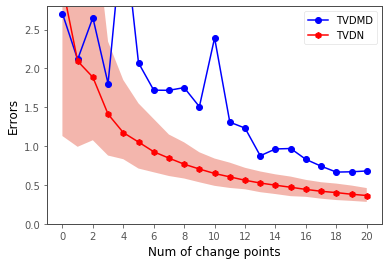

In [94]:
numPts = list(range(0, 21))
mDMDErr = [np.mean(DMDRecErrs[i]) for i in numPts]
quDMDErr = [np.quantile(DMDRecErrs[i], 0.975) for i in numPts]
qlDMDErr = [np.quantile(DMDRecErrs[i], 0.025) for i in numPts]
mTVDNErr = [np.mean(TVDNRecErrsSW[i]) for i in numPts]
quTVDNErr = [np.quantile(TVDNRecErrsSW[i], 0.975) for i in numPts]
qlTVDNErr = [np.quantile(TVDNRecErrsSW[i], 0.025) for i in numPts]

plt.plot(numPts, mDMDErr, "b-o", label="TVDMD")
#plt.plot(numPts, qlDMDErr, "b-.")
#plt.plot(numPts, quDMDErr, "b-.")
#plt.fill_between(numPts, qlDMDErr, quDMDErr, color="blue", alpha=0.4)
plt.plot(numPts, mTVDNErr, "r-h", label="TVDN")
#plt.plot(numPts, qlTVDNErr, "r-.")
#plt.plot(numPts, quTVDNErr, "r-.")
plt.fill_between(numPts, qlTVDNErr, quTVDNErr, alpha=0.4)
plt.xticks(numPts[::2])
plt.ylim([0, 2.8])
plt.ylabel("Errors")
plt.xlabel("Num of change points")
plt.legend()

# Correlation with the 7 canonical networks

In [20]:
import pandas as pd

def tmpF(name):
    splName = name.split("_")
    if len(splName) == 1:
        return splName[0]
    else:
        res = splName[0] 
        for splNam in splName[1:]:
            res = res + " " + splNam
        return res 

fcR = pd.read_csv("../necessary files/AALICA.csv")
names = list(fcR.columns)
names = [tmpF(name.strip()) for name in names]
fcR = np.array(fcR)
fcR = fcR[:90, :]

RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]
RcorF = robj.r["corF.fMRI"]

In [21]:
featuresWAll = {}
corWAll = {}
for wsize in [10, 20]:
    featuresW = ddict(list)
    corW = ddict(list)
    for DetObj in tqdm(TVDNres.DetObjs):
        Ymat = DetObj.Ymat
        d, n = Ymat.shape
        seqw = np.arange(1, n-wsize, 4)
        rSeqw = py2Rvec(seqw)
        rYmat = py2Rmat(Ymat)
        rfcR = py2Rmat(fcR)
        
        # Features and correlations for PCA
        rPCAres = RsegPCAOrg(rYmat, wsize, rSeqw, rank=rank)
        featuresW["PCA"].append(np.array(rPCAres))
        rPCAres = RcorF(rPCAres, rfcR)
        corW["PCA"].append(np.array(rPCAres))
        
        # Features and correlations for DMD
        rDMDres = RsegDMDOrg(rYmat, wsize, rSeqw, rank=rank)
        featuresW["DMD"].append(np.array(rDMDres))
        rDMDres = RcorF(rDMDres, rfcR)
        corW["DMD"].append(np.array(rDMDres))
        
    corWAll[wsize] = corW
    featuresWAll[wsize] = featuresW

In [22]:
DMDw10Cors = np.concatenate(corWAll[10]["DMD"])
PCAw10Cors = np.concatenate(corWAll[10]["PCA"])
DMDw20Cors = np.concatenate(corWAll[20]["DMD"])
PCAw20Cors = np.concatenate(corWAll[20]["PCA"])
TVDNCors = np.loadtxt(saveDir/"allCorr_healthy.txt")

DMDw10CorM = np.max(DMDw10Cors, axis=1)
PCAw10CorM = np.max(PCAw10Cors, axis=1)
DMDw20CorM = np.max(DMDw20Cors, axis=1)
PCAw20CorM = np.max(PCAw20Cors, axis=1)
TVDNCorM = np.max(TVDNCors, axis=1)

rawVs = list(TVDNCorM) + list(PCAw10CorM) + list(PCAw20CorM) + list(DMDw10CorM) + list(DMDw20CorM) 
violabs = ["TVDN"]*len(TVDNCorM) + ["TVPCA wsize=10"]*len(PCAw10CorM) +  ["TVPCA wsize=20"]*len(PCAw20CorM) + \
        ["TVDMD wsize=10"]* len(DMDw10CorM) + ["TVDMD wsize=20"]* len(DMDw20CorM) 
       

In [23]:
maxPosIdxDMDw10 = np.argmax(DMDw10Cors, axis=1)
maxPosIdxPCAw10 = np.argmax(PCAw10Cors, axis=1)
maxPosIdxDMDw20 = np.argmax(DMDw20Cors, axis=1)
maxPosIdxPCAw20 = np.argmax(PCAw20Cors, axis=1)
maxPosIdxTVDN = np.argmax(TVDNCors, axis=1)

PosPCAw10CT = Counter(maxPosIdxPCAw10)
PosDMDw10CT = Counter(maxPosIdxDMDw10)
PosPCAw20CT = Counter(maxPosIdxPCAw20)
PosDMDw20CT = Counter(maxPosIdxDMDw20)
PosTVDNCT = Counter(maxPosIdxTVDN)
barPosPCAw10 = [PosPCAw10CT[i]/len(maxPosIdxPCAw10) for i in range(7)]
barPosDMDw10 = [PosDMDw10CT[i]/len(maxPosIdxDMDw10) for i in range(7)]
barPosPCAw20 = [PosPCAw20CT[i]/len(maxPosIdxPCAw20) for i in range(7)]
barPosDMDw20 = [PosDMDw20CT[i]/len(maxPosIdxDMDw20) for i in range(7)]
barPosTVDN = [PosTVDNCT[i]/len(maxPosIdxTVDN) for i in range(7)]

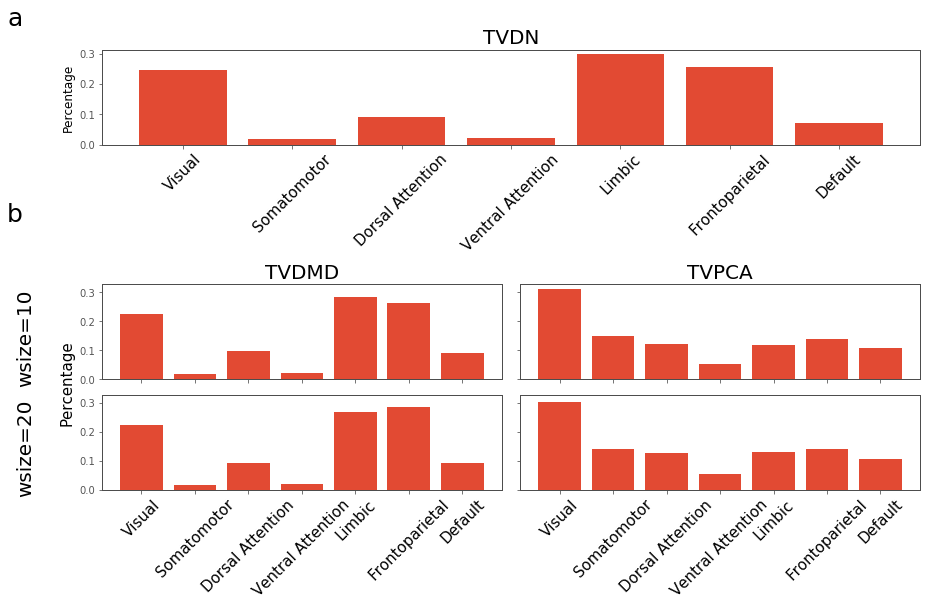

In [24]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)

gs = gridspec.GridSpec(3, 2, figure=fig)

ax1 = plt.subplot(gs[0,:])
ax1.bar(names, barPosTVDN)
ax1.set_ylabel("Percentage")
ax1.set_title("TVDN", fontsize=20)
ax1.set_xticklabels(names, rotation=45, color="black", fontsize=15)

ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1], sharex=ax2, sharey=ax2)
ax4 = plt.subplot(gs[2, 0], sharex=ax2, sharey=ax2)
ax5 = plt.subplot(gs[2, 1], sharex=ax2, sharey=ax2)

ax2.bar(names, barPosDMDw10)
ax2.set_title("TVDMD", fontsize=20)
ax2.tick_params(labelbottom=False)

ax3.bar(names, barPosPCAw10)
ax3.set_title("TVPCA", fontsize=20)
ax3.tick_params(labelbottom=False, labelleft=False)


ax4.bar(names, barPosDMDw20)
ax4.set_xticklabels(names, rotation=45, color="black", fontsize=15)

ax5.bar(names, barPosPCAw20)
ax5.tick_params(labelleft=False)
ax5.set_xticklabels(names, rotation=45, color="black", fontsize=15)

fig.text(-0.06, 1, "a", fontsize=25)
fig.text(-0.06, 0.66, "b", fontsize=25)

fig.text(-0.00, 0.38, 'Percentage', va='center', rotation="vertical", fontsize=15, color="black")

#fig.text(-0.05, 0.58, "wsize", rotation="horizontal", fontsize=20)
fig.text(-0.05, 0.38, "wsize=10", rotation="vertical", fontsize=20)
fig.text(-0.05, 0.19, "wsize=20", rotation="vertical", fontsize=20)

plt.savefig("../plots/fMRI_corr_err_healthy.jpg", bbox_inches='tight')

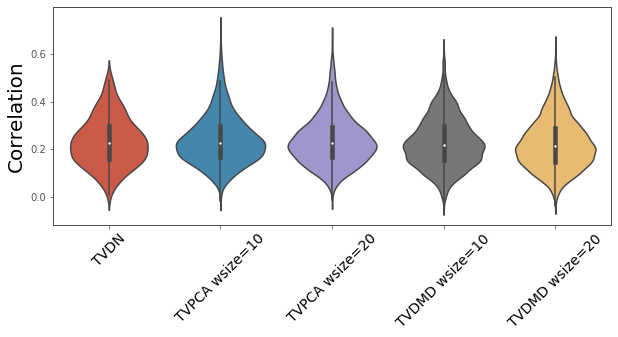

In [25]:
plt.figure(figsize=[10, 4])
sns.violinplot(y=rawVs, x=violabs)
plt.ylabel("Correlation", fontsize=20)
plt.xticks(color="black", fontsize=14, rotation=45)
plt.savefig(f"../plots/fMRI_violin_healthy.jpg", bbox_inches='tight')

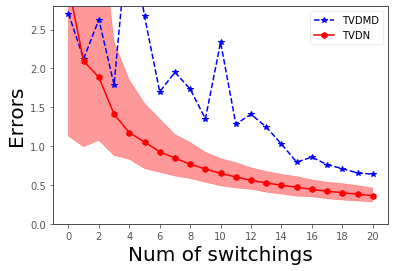

In [26]:
plt.figure(figsize=[6, 4])
plt.plot(numPts, mDMDErr, "b--*", label="TVDMD")
plt.plot(numPts, mTVDNErr, "r-h", label="TVDN")
plt.fill_between(numPts, qlTVDNErr, quTVDNErr, alpha=0.4, color="red")
plt.xticks(numPts[::2])
plt.ylabel("Errors", fontsize=20)
plt.ylim([0, 2.8])
plt.xlabel("Num of switchings", fontsize=20)
plt.legend()
plt.savefig(f"../plots/fMRI_DMD_vs_TVDN_healthy.jpg", bbox_inches='tight')

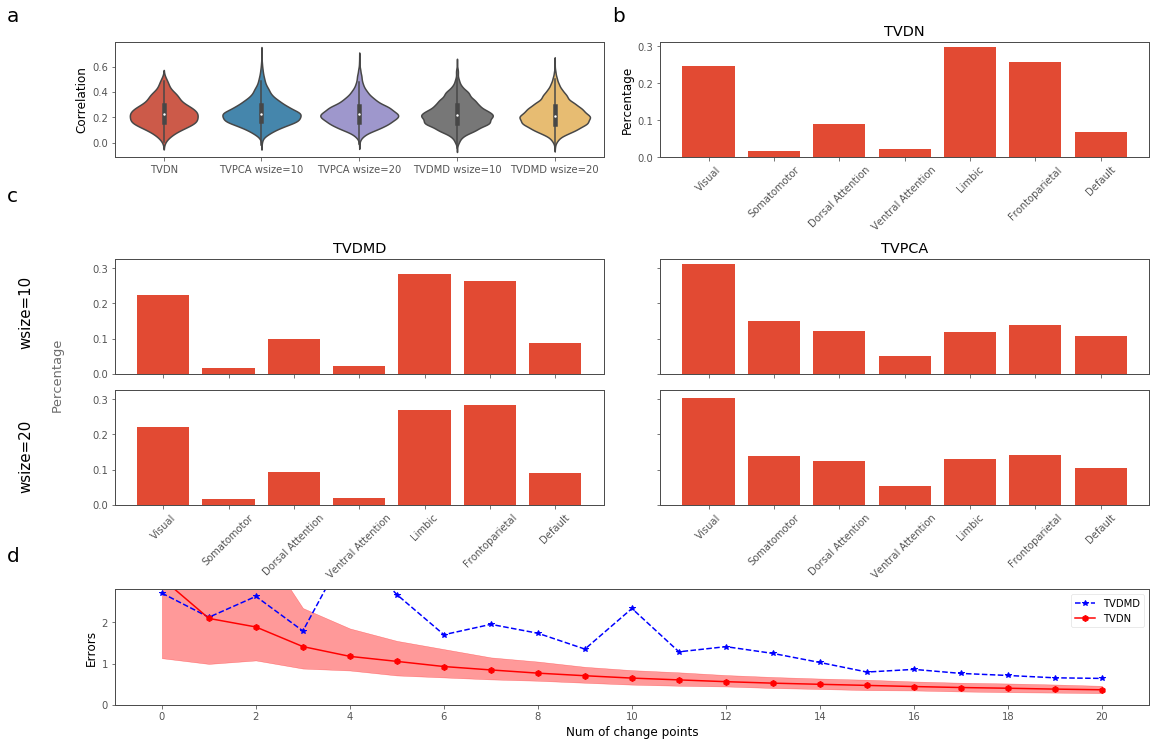

In [27]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)

gs = gridspec.GridSpec(4, 2, figure=fig)

ax0 = plt.subplot(gs[0, 0])
sns.violinplot(y=rawVs, x=violabs)
_ = plt.ylabel("Correlation")

ax1 = plt.subplot(gs[0,1])
ax1.bar(names, barPosTVDN)
ax1.set_ylabel("Percentage")
ax1.set_title("TVDN")
ax1.set_xticklabels(names, rotation=45)

ax6 = plt.subplot(gs[3, :])

ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1], sharex=ax2, sharey=ax2)
ax4 = plt.subplot(gs[2, 0], sharex=ax2, sharey=ax2)
ax5 = plt.subplot(gs[2, 1], sharex=ax2, sharey=ax2)

ax2.bar(names, barPosDMDw10)
ax2.set_title("TVDMD")
ax2.tick_params(labelbottom=False)

ax3.bar(names, barPosPCAw10)
ax3.set_title("TVPCA")
ax3.tick_params(labelbottom=False, labelleft=False)


ax4.bar(names, barPosDMDw20)
ax4.set_xticklabels(names, rotation=45)

ax5.bar(names, barPosPCAw20)
ax5.tick_params(labelleft=False)
ax5.set_xticklabels(names, rotation=45)

ax6.plot(numPts, mDMDErr, "b--*", label="TVDMD")
ax6.plot(numPts, mTVDNErr, "r-h", label="TVDN")
ax6.fill_between(numPts, qlTVDNErr, quTVDNErr, alpha=0.4, color="red")
ax6.set_xticks(numPts[::2])
ax6.set_ylabel("Errors")
ax6.set_ylim([0, 2.8])
ax6.set_xlabel("Num of change points")
ax6.legend()

fig.text(0.50, 1, "b", fontsize=20)
fig.text(-0.06, 1, "a", fontsize=20)
fig.text(-0.06, 0.75, "c", fontsize=20)
fig.text(-0.06, 0.25, "d", fontsize=20)

fig.text(-0.02, 0.51, 'Percentage', va='center', rotation="vertical", fontsize=13, color="#6D6D6D")

fig.text(-0.05, 0.55, "wsize=10", rotation="vertical", fontsize=15)
fig.text(-0.05, 0.35, "wsize=20", rotation="vertical", fontsize=15)

plt.savefig("../plots/fMRI_corr_err2_healthy.jpg", bbox_inches='tight')

## Demo result: fMRI  

### Results for DCOR, DMD and PCA

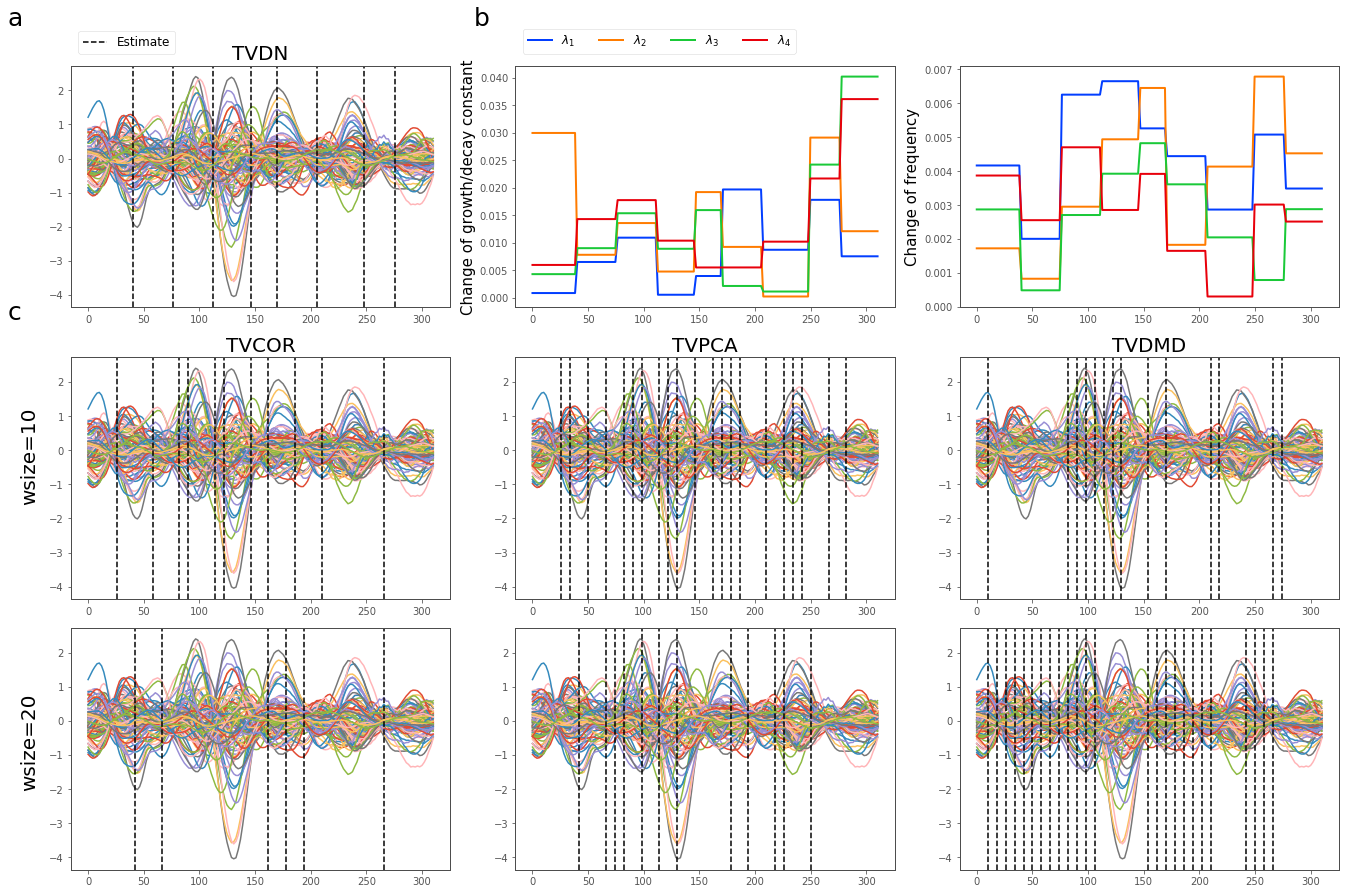

In [65]:
idx = 91
DetObj = TVDNres.DetObjs[idx]

d, n = DetObj.nYmat.shape
acTime = n / DetObj.paras.freq
ajfct = n/acTime
ptime = DetObj.ptime
Ymat = DetObj.Ymat
brainDir = Path("../plots/")
brainPlots = list(brainDir.glob(f"fMRIM8_{idx}*.jpg"))
brainPlots = sorted(brainPlots, key=lambda x: int(x.stem.split("_")[-1]))

freq = DetObj.paras.freq
numChgCur = len(DetObj.ecpts)
LamMs = DetObj.RecResCur.LamMs
rAct, n = LamMs.shape
pltIdxs = np.arange(1, rAct)[np.diff(np.abs(LamMs), axis=0).astype(np.bool).all(axis=1)] 
pltIdxs = np.concatenate([[0], pltIdxs])
ReLamMs = freq*LamMs.real/(acTime/DetObj.paras.T)
ImLamMs = freq*LamMs.imag/((2*np.pi)*(acTime/DetObj.paras.T))
cols = sns.color_palette("bright", len(pltIdxs))

fig = plt.figure(figsize=(18, 12), constrained_layout=True)
gs = gridspec.GridSpec(3, 6, figure=fig)

ax0 = plt.subplot(gs[0, 0:2])
ax6 = plt.subplot(gs[0, 2:4])
ax7 = plt.subplot(gs[0, 4:6])

for i in range(d):
    ax0.plot(ptime, Ymat[i, :], "-")
for ii, ecpt in enumerate(DetObj.ecpts):
    if ii == 0:
        ax0.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
    else:
        ax0.axvline(ecpt/ajfct, color="black", linestyle="--")
ax0.set_title("TVDN", fontsize=20)

for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    ax6.plot(DetObj.ptime, np.abs(ReLamMs[i, :]), label=labs,  color=cols[i0], linewidth=2)
ax6.set_ylabel("Change of growth/decay constant", fontsize=15)
#ax6.set_xlabel("Time")
#ax6.legend(loc="upper left")

for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    ax7.plot(DetObj.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
ax7.set_ylabel("Change of frequency", fontsize=15)
#ax7.set_ylim([0, 0.01])
#ax7.set_xlabel("Time")
#ax7.legend(loc="upper left")

ax8  = plt.subplot(gs[1, 0:2])
ax9  = plt.subplot(gs[1, 4:6])
ax10 = plt.subplot(gs[1, 2:4])
ax11 = plt.subplot(gs[2, 0:2])
ax12 = plt.subplot(gs[2, 4:6])
ax13 = plt.subplot(gs[2, 2:4])

for i in range(d):
    ax8.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[10]["DCOR"][idx]:
    ax8.axvline(ecpt/ajfct, color="black", linestyle="--")
ax8.set_title("TVCOR", fontsize=20)
#ax8.set_xticklabels([])

for i in range(d):
    ax9.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[10]["DMD"][idx]:
    ax9.axvline(ecpt/ajfct, color="black", linestyle="--")
ax9.set_title("TVDMD", fontsize=20)
#ax9.set_xticklabels([])
#ax9.set_yticklabels([])

for i in range(d):
    ax10.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[10]["PCA"][idx]:
    ax10.axvline(ecpt/ajfct, color="black", linestyle="--")
ax10.set_title("TVPCA", fontsize=20)
#ax10.set_xticklabels([])
#ax10.set_yticklabels([])

for i in range(d):
    ax11.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[20]["DCOR"][idx]:
    ax11.axvline(ecpt/ajfct, color="black", linestyle="--")

for i in range(d):
    ax12.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[20]["DMD"][idx]:
    ax12.axvline(ecpt/ajfct, color="black", linestyle="--")
#ax12.set_yticklabels([])

for i in range(d):
    ax13.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[20]["PCA"][idx]:
    ax13.axvline(ecpt/ajfct, color="black", linestyle="--")
#ax13.set_yticklabels([])

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc=(0.02, 1.05), ncol=1, prop={'size': 12})
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels, loc=(0.02, 1.05), ncol=5, prop={'size': 12})

fig.text(-0.02, 0.45, "wsize=10", rotation="vertical", fontsize=20)
_ = fig.text(-0.02, 0.12, "wsize=20", rotation="vertical", fontsize=20)

fig.text(-0.03, 1, "a", fontsize=25)
fig.text(0.33, 1, "b", fontsize=25)
#fig.text(0.78, 1, "c", fontsize=20)
_ = fig.text(-0.03, 0.66, "c", fontsize=25)
plt.savefig(f"../plots/fMRI_demo_{idx}_combo_healthy.jpg", bbox_inches='tight')

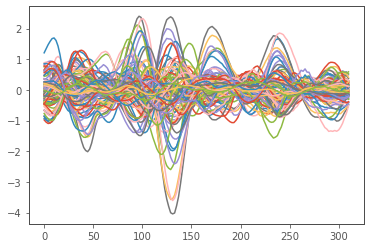

In [66]:
fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVDN_raw_healthy.jpg", bbox_inches='tight')

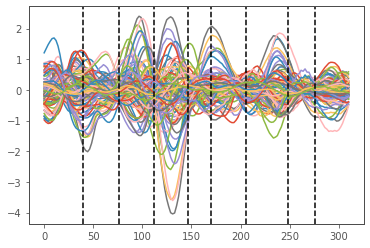

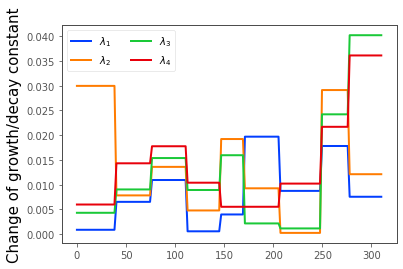

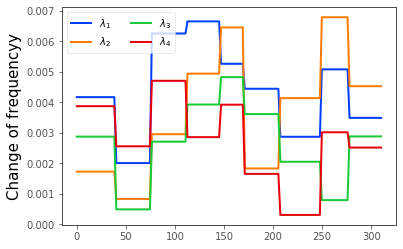

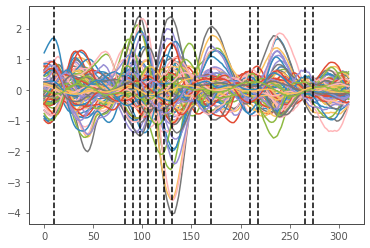

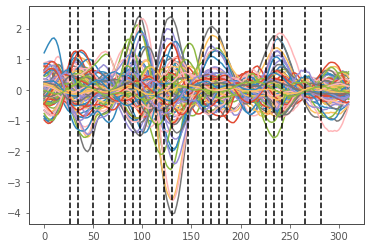

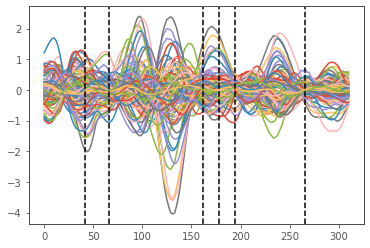

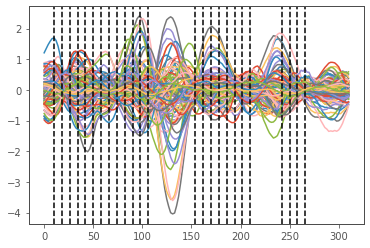

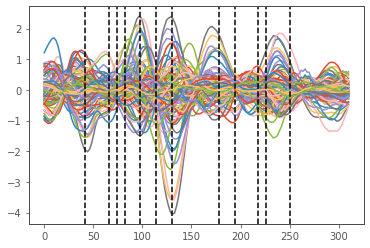

In [67]:
DetObj = TVDNres.DetObjs[idx]

d, n = DetObj.nYmat.shape
acTime = n / DetObj.paras.freq
ajfct = n/acTime
ptime = DetObj.ptime
Ymat = DetObj.Ymat
brainDir = Path("../plots/")
brainPlots = list(brainDir.glob(f"fMRIM8_{idx}*.jpg"))
brainPlots = sorted(brainPlots, key=lambda x: int(x.stem.split("_")[-1]))

freq = DetObj.paras.freq
numChgCur = len(DetObj.ecpts)
LamMs = DetObj.RecResCur.LamMs
rAct, n = LamMs.shape
pltIdxs = np.arange(1, rAct)[np.diff(np.abs(LamMs), axis=0).astype(np.bool).all(axis=1)] 
pltIdxs = np.concatenate([[0], pltIdxs])
ReLamMs = freq*LamMs.real/(acTime/DetObj.paras.T)
ImLamMs = freq*LamMs.imag/((2*np.pi)*(acTime/DetObj.paras.T))
cols = sns.color_palette("bright", len(pltIdxs))

fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
for ecpt in DetObj.ecpts:
    plt.axvline(ecpt/ajfct, color="black", linestyle="--")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVDN_ecpts_healthy.jpg", bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(DetObj.ptime, np.abs(ReLamMs[i, :]), label=labs,  color=cols[i0], linewidth=2)
plt.ylabel("Change of growth/decay constant", fontsize=15)
plt.legend(loc="upper left", ncol=2)
#plt.ylim([0, 0.06])
plt.savefig(f"../plots/fMRI_demo_{idx}_TVDN_eigReal_healthy.jpg", bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(DetObj.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
plt.ylabel("Change of frequencyy", fontsize=15)
#plt.ylim([0, 0.01])
plt.legend(loc="upper left", ncol=2)
plt.savefig(f"../plots/fMRI_demo_{idx}_TVDN_eigImag_healthy.jpg", bbox_inches='tight')


fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[10]["DCOR"][idx]:
    plt.axvline(ecpt/ajfct, color="black", linestyle="--")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVCOR_w10_ecpts_healthy.jpg", bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[10]["DMD"][idx]:
    plt.axvline(ecpt/ajfct, color="black", linestyle="--")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVDMD_w10_ecpts_healthy.jpg", bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[10]["PCA"][idx]:
    plt.axvline(ecpt/ajfct, color="black", linestyle="--")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVPCA_w10_ecpts_healthy.jpg", bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[20]["DCOR"][idx]:
    plt.axvline(ecpt/ajfct, color="black", linestyle="--")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVCOR_w20_ecpts_healthy.jpg", bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[20]["DMD"][idx]:
    plt.axvline(ecpt/ajfct, color="black", linestyle="--")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVDMD_w20_ecpts_healthy.jpg", bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
for i in range(d):
    plt.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgswAll[20]["PCA"][idx]:
    plt.axvline(ecpt/ajfct, color="black", linestyle="--")
plt.savefig(f"../plots/fMRI_demo_{idx}_TVPCA_w20_ecpts_healthy.jpg", bbox_inches='tight')

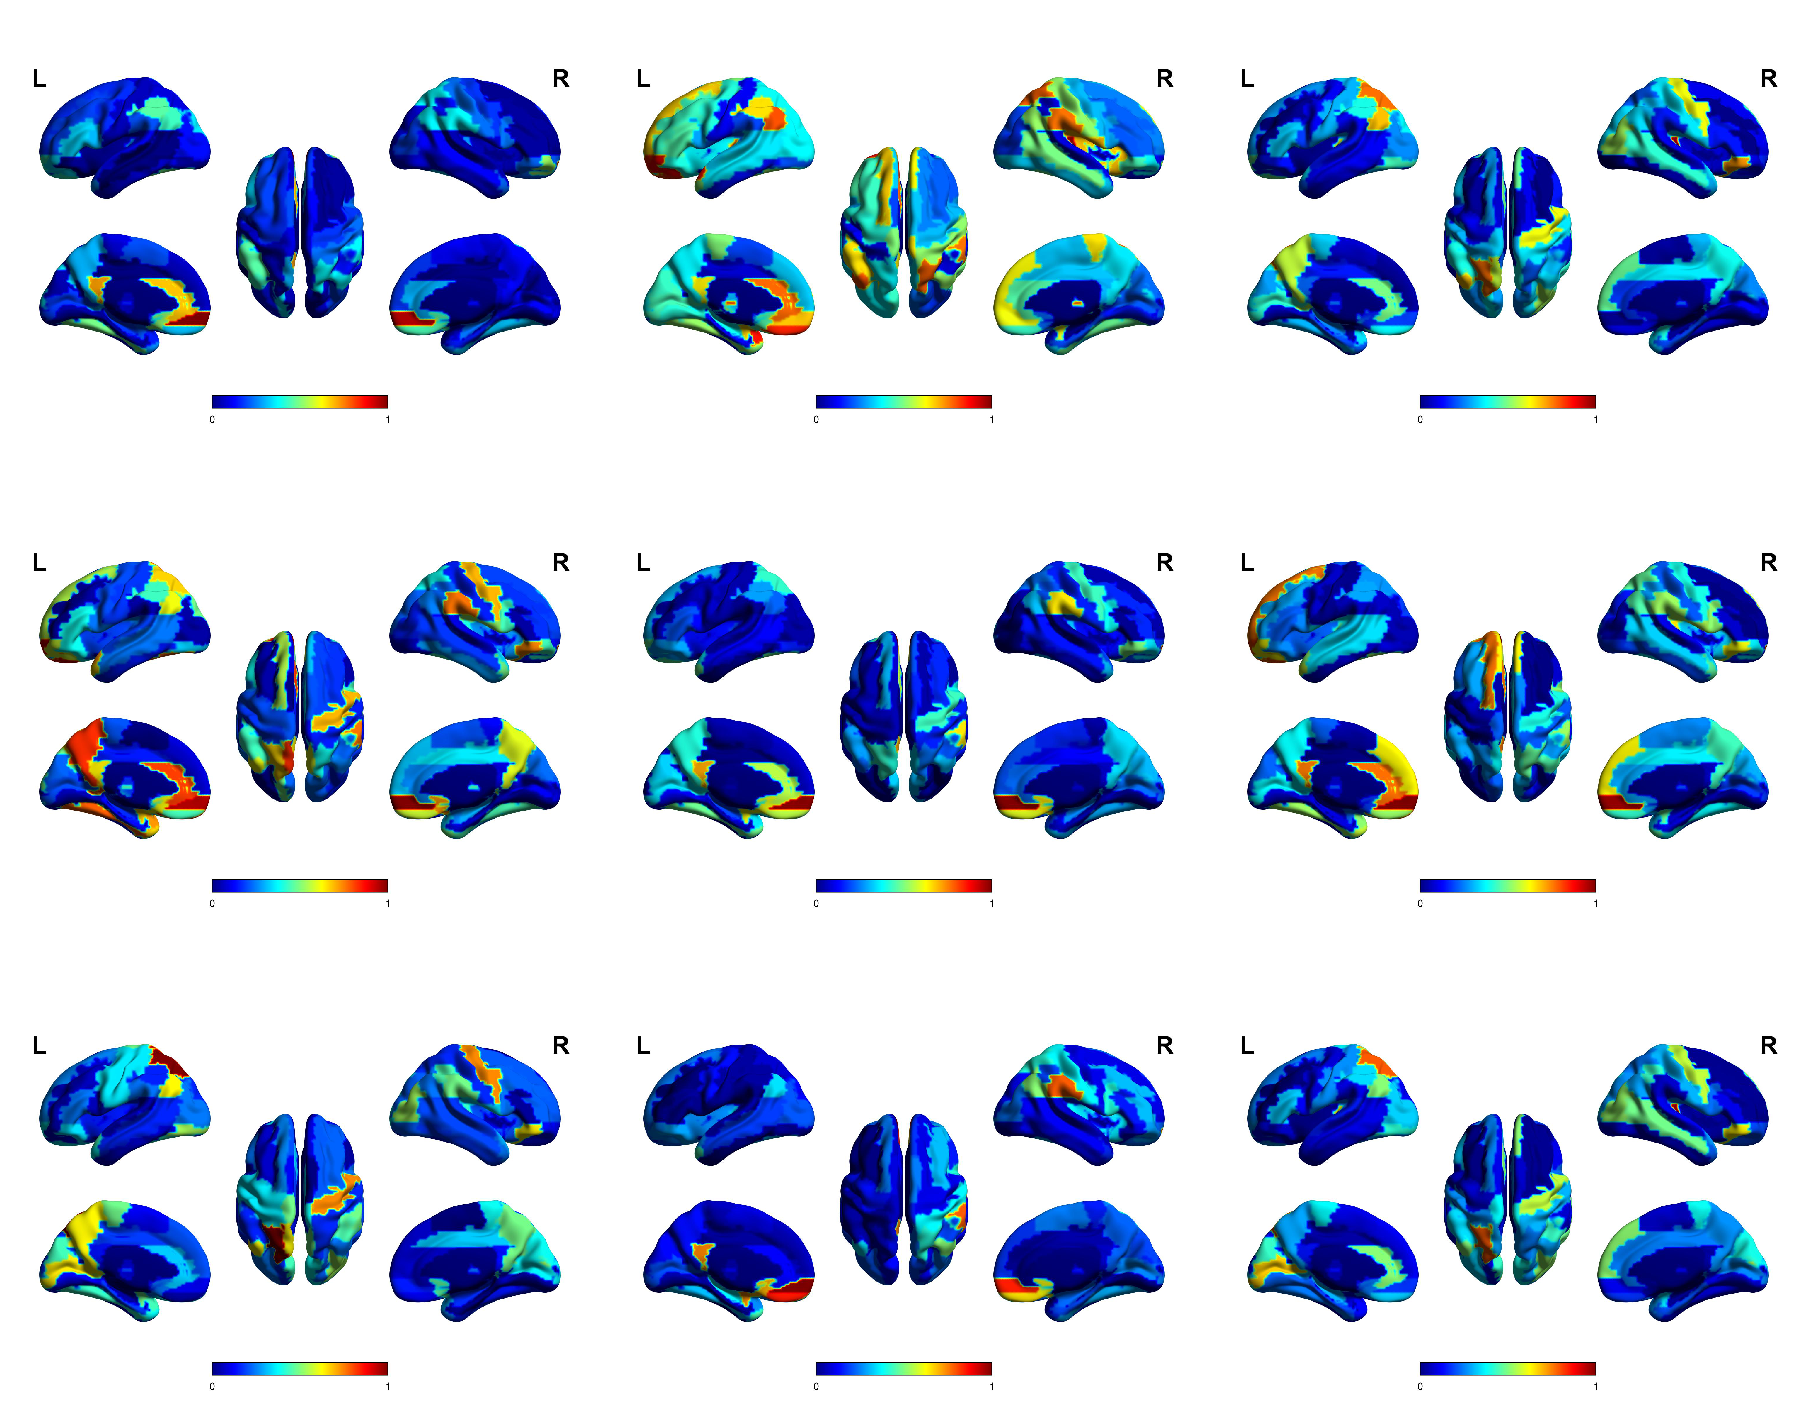

In [68]:
brainDir = Path(f"../plots/")
brainPlots = list(brainDir.glob(f"fMRIM8_{idx}*.jpg"))
brainPlots = sorted(brainPlots, key=lambda x: int(x.stem.split("_")[-1]))

fig = plt.figure(figsize=(25, 20), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, figure=fig)


ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])
ax7 = plt.subplot(gs[2, 0])
ax8 = plt.subplot(gs[2, 1])
ax9 = plt.subplot(gs[2, 2])


axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
for idx1, ax in enumerate(axs):
    img = plt.imread(brainPlots[idx1])
    ax.imshow(img)
    ax.axis("off")
plt.savefig(f"../plots/fMRI_demo_{idx}_brain_combo_healthy.jpg", bbox_inches='tight')